<a href="https://colab.research.google.com/github/adildafedar/Artificial-Intelligence/blob/main/Assignment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 7
Implement Image compression using DCT Transform and Huffman Coding. Perform all these operations on any open source image dataset and analyse the effect of lossy and lossless image compression. Prepare a report on the same and suggest the suitable technique for image compression based on the samples in dataset.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from skimage.metrics import structural_similarity as ssim

Q50 = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]
])

In [6]:
def scale_quant_matrix(QF):
    if QF < 50:
        scale = 5000 / QF
    else:
        scale = 200 - 2 * QF
    Q = np.floor((Q50 * scale + 50) / 100)
    Q[Q == 0] = 1
    return Q

def dct_compress(img, Q):
    h, w = img.shape
    pad_h = (8 - h % 8) % 8
    pad_w = (8 - w % 8) % 8
    padded = np.pad(img, ((0,pad_h),(0,pad_w)), mode='constant')

    compressed = np.zeros_like(padded, dtype=float)
    for i in range(0, padded.shape[0], 8):
        for j in range(0, padded.shape[1], 8):
            block = padded[i:i+8, j:j+8]
            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
            compressed[i:i+8, j:j+8] = np.round(dct_block / Q)
    return compressed, padded.shape

def dct_decompress(compressed, original_shape, Q):
    h, w = compressed.shape
    decompressed = np.zeros((h, w))
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = compressed[i:i+8, j:j+8] * Q
            idct_block = idct(idct(block.T, norm='ortho').T, norm='ortho')
            decompressed[i:i+8, j:j+8] = idct_block
    decompressed = np.clip(decompressed, 0, 255)
    return decompressed[:original_shape[0], :original_shape[1]].astype(np.uint8)

In [3]:
def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def compression_ratio(original_size, compressed_size):
    return original_size / compressed_size

def bits_per_pixel(compressed_bits, img_shape):
    return compressed_bits / (img_shape[0] * img_shape[1])

In [4]:
img = cv2.imread('OIP (1).jpeg', cv2.IMREAD_GRAYSCALE)

In [7]:
Q_factors = [90, 70, 50, 30, 10]

results = []

for QF in Q_factors:
    Q = scale_quant_matrix(QF)
    compressed, shape = dct_compress(img, Q)
    decompressed = dct_decompress(compressed, img.shape, Q)

    # Estimate size (approximate bits)
    # Assume each quantized coefficient stored as int16
    original_bits = img.size * 8  # 8 bits per pixel original
    compressed_bits = compressed.size * 16  # 16 bits per quantized coeff

    cr = compression_ratio(original_bits, compressed_bits)
    bpp = bits_per_pixel(compressed_bits, img.shape)
    p = psnr(img, decompressed)
    s = ssim(img, decompressed)

    results.append({
        'QF': QF,
        'compressed_img': decompressed,
        'CR': cr,
        'bpp': bpp,
        'PSNR': p,
        'SSIM': s
    })

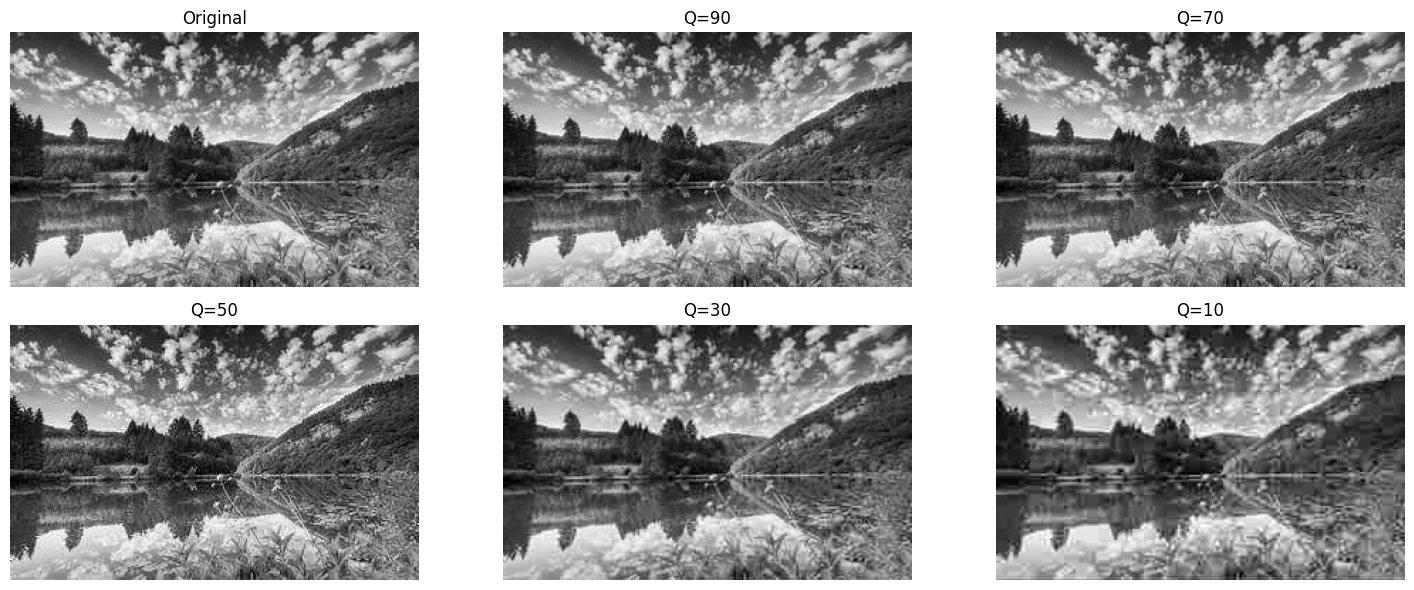

In [8]:
plt.figure(figsize=(15,6))
plt.subplot(2,3,1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')

for i, res in enumerate(results):
    plt.subplot(2,3,i+2)
    plt.imshow(res['compressed_img'], cmap='gray')
    plt.title(f"Q={res['QF']}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
import pandas as pd

df = pd.DataFrame({
    'Quality Factor': [r['QF'] for r in results],
    'Compression Ratio': [round(r['CR'], 2) for r in results],
    'Bits per Pixel (bpp)': [round(r['bpp'], 2) for r in results],
    'PSNR (dB)': [round(r['PSNR'], 2) for r in results],
    'SSIM': [round(r['SSIM'], 3) for r in results]
})

df = df[['Quality Factor', 'Compression Ratio', 'Bits per Pixel (bpp)', 'PSNR (dB)', 'SSIM']]
print(df)

   Quality Factor  Compression Ratio  Bits per Pixel (bpp)  PSNR (dB)   SSIM
0              90               0.49                 16.36      48.26  0.999
1              70               0.49                 16.36      44.09  0.999
2              50               0.49                 16.36      32.42  0.966
3              30               0.49                 16.36      30.37  0.883
4              10               0.49                 16.36      29.32  0.761


#Conclusion

DCT-based lossy compression effectively reduces image size with controllable quality loss, where a moderate quality factor (50–70) balances compression and visual fidelity. Huffman coding offers lossless compression but with lower size reduction. Choosing the right method depends on whether preserving exact image data or achieving higher compression is more important.